## Capstone Project - The Battle of Neighborhoods!

Business Objective :

Identify the best location to setup a coffee shop in Bangalore based on location proximity and ratings of existing shops in the neighborhood.


In [76]:
### import required libraries
import pandas as pd
from bs4 import BeautifulSoup 
import requests
import warnings
warnings.filterwarnings("ignore")
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
### Scrap the list of Neighborhoods from Wikipedia 
Bangalore = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore').text
bs=BeautifulSoup(Bangalore,'html.parser')

In [5]:
### Reading the multiple table contents
table_contents=[]
cnt=0
for row in bs.findAll('tr'):
    cell={}
    for val in (row.findAll('td')) :
        
        cnt=cnt+1
        #print("value",val.text)
        if cnt==1 :
            cell['Name'] = val.text
            cnt=1
        elif cnt==2 :
            cnt=2
        elif cnt==3  :
            cell['Description'] = val.text
            cnt=0
        table_contents.append(cell)

In [6]:
df=pd.DataFrame(table_contents)
df['Name']=df['Name'].str.rstrip()
df['Description']=df['Description'].str.rstrip()

In [8]:
bangalore_df=df[0:73]

In [72]:
### Number of unique Neighborhoods
len(bangalore_df['Name'].unique())

65

In [9]:
## reading geocodes
blr_geocode=pd.read_csv('blr_neighborhood.csv')
blr_geocode

,Name,Lat,Lon
0,Cantonment area,12.993690,77.598142
1,Domlur,12.960992,77.638726
2,Indiranagar,12.971891,77.641151
3,Rajajinagar,12.998200,77.553000
4,Malleswaram,13.005459,77.569199
...,...,...,...
59,Nandini Layout,13.013700,77.533900
60,Nayandahalli,12.944600,77.525600
61,Rajajinagar,12.998200,77.553000
62,Rajarajeshwari Nagar,12.914900,77.520600


### Reading Geocode and merge with Neighborhood data

In [10]:
### merge with the initial dataset of Neighborhood list.
blr_df=pd.merge(bangalore_df,blr_geocode, on='Name',how='left')
blr_df

,Name,Description,Lat,Lon
0,NaN,NaN,NaN,NaN
1,Cantonment area,The Cantonment area in Bangalore was used as a...,12.993690,77.598142
2,Domlur,"Formerly part of the Cantonment area, Domlur h...",12.960992,77.638726
3,Indiranagar,Indiranagar is a sought-after residential and ...,12.971891,77.641151
4,Rajajinagar,Established in 1949 on the birthday of C. Raja...,12.998200,77.553000
...,...,...,...,...
70,Nayandahalli,Nayandahalli is a transport junction in the we...,12.944600,77.525600
71,Rajajinagar,,12.998200,77.553000
72,Rajajinagar,,12.998200,77.553000
73,Rajarajeshwari Nagar,Located in the south-western part of the city ...,12.914900,77.520600


In [11]:
### Dropping any nulls
blr_df=blr_df.dropna()

In [12]:
### Visualize the Neighborhood locations on Map
tmap = folium.Map(location=[12.9716,77.5946],zoom_start=10)

for lat,lng,Neighborhood in zip(blr_df['Lat'],blr_df['Lon'],blr_df['Name']):
    label = '{}'.format(Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(tmap)

In [13]:
tmap

### Extract data from FourSquare 

In [15]:
### Defining Client ID  and other information 
CLIENT_ID = 'XXXX' 
CLIENT_SECRET = 'XXX' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
OAUTH_TOKEN='XXX'
radius=500

In [16]:
# create the API request URL and fetch results for Coffee shops in each Neighborhood

venues_list=[]
for name, lat, lng in zip(blr_df['Name'], blr_df['Lat'], blr_df['Lon']):
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&oauth_token={}&radius={}&query=coffee&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            OAUTH_TOKEN,
            radius, 
            LIMIT)
            
        # make the GET request
    results = requests.get(url).json()
    for i in range(0,len(results['response']['venues'])):
        venues_list.append([(
                name, 
                lat, 
                lng, 
                results['response']['venues'][i]['name'],
                results['response']['venues'][i]['id'])])

coffee_shops = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
coffee_shops.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Coffee Shop Name', 
                  'Coffee Shop ID']
        

In [25]:
coffee_shops

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Coffee Shop Name,Coffee Shop ID
0,Cantonment area,12.993690,77.598142,Cafe Coffee Day,4ddbae17fa7637ab73dfc532
1,Indiranagar,12.971891,77.641151,Costa Coffee,4da0536f58c2224b2a784f79
2,Indiranagar,12.971891,77.641151,Cafe Coffee Day,4c5bf903adfdef3bcb3a587f
3,Indiranagar,12.971891,77.641151,Cafe Coffee Day,4becf34d1d5576b09f99beea
4,Indiranagar,12.971891,77.641151,Third Wave Coffee Roasters,5de1f0470dab60000849a207
...,...,...,...,...,...
123,Rajajinagar,12.998200,77.553000,Cafe Coffee Day,5139e8f2e4b0a12e4345ede8
124,Rajajinagar,12.998200,77.553000,Hatti Coffee,4f406bb6e4b0d395c752f2c2
125,Rajajinagar,12.998200,77.553000,Cafe Coffee Day,50d46718e4b05f366ce43cc9
126,Rajajinagar,12.998200,77.553000,KLE's Just Coffee,52a5c0d911d2fc3af3794489


In [30]:
### Fetch Rating information for every coffee shop 
rating_list=[]
for idx in coffee_shops['Coffee Shop ID']:
    #print(idx)
    url_rating='https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            idx,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results_rating = requests.get(url_rating).json()
    if ('venue' in results_rating['response']):
        
        if ('rating' in results_rating['response']['venue']):
            
            rating_list.append([(idx,  results_rating['response']['venue']['rating'])])
            #print(rating_list)
    


[[('4ddbae17fa7637ab73dfc532', 6.4)]]
[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)]]
[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)], [('4c5bf903adfdef3bcb3a587f', 6.1)]]
[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)], [('4c5bf903adfdef3bcb3a587f', 6.1)], [('4becf34d1d5576b09f99beea', 5.1)]]
[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)], [('4c5bf903adfdef3bcb3a587f', 6.1)], [('4becf34d1d5576b09f99beea', 5.1)], [('50d46718e4b05f366ce43cc9', 6.4)]]
[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)], [('4c5bf903adfdef3bcb3a587f', 6.1)], [('4becf34d1d5576b09f99beea', 5.1)], [('50d46718e4b05f366ce43cc9', 6.4)], [('5139e8f2e4b0a12e4345ede8', 6.3)]]
[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)], [('4c5bf903adfdef3bcb3a587f', 6.1)], [('4becf34d1d5576b09f99beea', 5.1)], [('50d46718e4b05f366ce43cc9', 6.4)], [('5139e8f2e4b0a12e4345ede8', 6

[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)], [('4c5bf903adfdef3bcb3a587f', 6.1)], [('4becf34d1d5576b09f99beea', 5.1)], [('50d46718e4b05f366ce43cc9', 6.4)], [('5139e8f2e4b0a12e4345ede8', 6.3)], [('50d46718e4b05f366ce43cc9', 6.4)], [('5139e8f2e4b0a12e4345ede8', 6.3)], [('4d5b74b2af4a5941c4b5f714', 6.6)], [('4c600aa990b2c9b6ead43b22', 5.1)], [('4db2ccd64b226b343d695f0b', 6.3)], [('4f9d2f87e4b0a3d1dcdc3630', 7.7)], [('4c839001d8086dcb56dd8052', 6.4)], [('4c407eb1ce54e21e8891091a', 6.2)], [('4c80d6e8d34ca1438f5b1c80', 6.3)], [('4c4c019f9e6dbe9a9e06db0c', 5.9)], [('4c35837c213c2d7f94453a5d', 5.6)], [('56019fd5498ec7fbc231bcaa', 6.5)], [('4c61510a924b76b0b01dfbb9', 5.9)], [('4cf2437a94feb1f7e4631cba', 7.1)], [('4bb865c6cf2fc9b64d849f02', 6.8)], [('5035f240e4b06e9703dcd5f8', 6.3)]]
[[('4ddbae17fa7637ab73dfc532', 6.4)], [('4da0536f58c2224b2a784f79', 6.3)], [('4c5bf903adfdef3bcb3a587f', 6.1)], [('4becf34d1d5576b09f99beea', 5.1)], [('50d46718e4b05f366ce43cc9', 6.4)],

In [32]:
ratings_df=pd.DataFrame([item for rating_list in rating_list for item in rating_list])
ratings_df.columns=['Coffee Shop ID', 'rating']

In [33]:
ratings_df

,Coffee Shop ID,rating
0,4ddbae17fa7637ab73dfc532,6.4
1,4da0536f58c2224b2a784f79,6.3
2,4c5bf903adfdef3bcb3a587f,6.1
3,4becf34d1d5576b09f99beea,5.1
4,50d46718e4b05f366ce43cc9,6.4
5,5139e8f2e4b0a12e4345ede8,6.3
6,50d46718e4b05f366ce43cc9,6.4
7,5139e8f2e4b0a12e4345ede8,6.3
8,4d5b74b2af4a5941c4b5f714,6.6
9,4c600aa990b2c9b6ead43b22,5.1


In [34]:
### Merge the Coffee shop and Rating dataframe.
coffee_final_df=pd.merge(coffee_shops,ratings_df,on='Coffee Shop ID', how='left')

In [35]:
### Replace No rating with -1.
coffee_final_df['rating'].fillna(-1,inplace=True)

#### Analyse the coffee shops with rating

In [ ]:
filter_df=coffee_final_df.loc[(coffee_final_df['rating']>-1)]

In [73]:
filter_df.shape

(37, 7)

In [74]:
filter_df['rating'].describe()

count    37.000000
mean      6.337838
std       0.461490
min       5.100000
25%       6.300000
50%       6.300000
75%       6.400000
max       7.700000
Name: rating, dtype: float64

## Clustering

### Elbow Method - Coffee shops with Rating

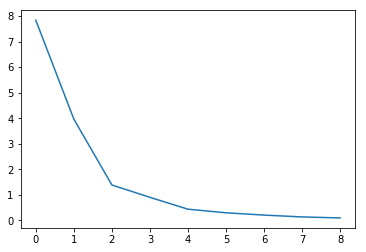

In [49]:
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(filter_df[['Neighborhood Latitude','Neighborhood Longitude','rating']])
    ssd.append(model_clus.inertia_)

plt.plot(ssd)
plt.show()

### Coffee shops in Neighborhood

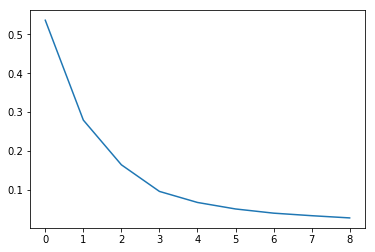

In [39]:
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(coffee_final_df[['Neighborhood Latitude','Neighborhood Longitude']])
    ssd.append(model_clus.inertia_)

plt.plot(ssd)
plt.show()


### Clustering - Coffee shops in Neighborhood

In [42]:
### Cluster neighborhood for proximity 
cls_neighbor=KMeans(n_clusters=3, random_state=0).fit(coffee_final_df[['Neighborhood Latitude','Neighborhood Longitude']])
coffee_final_df['Cluster Labels']=cls_neighbor.labels_

#### Analysis of Clusters

In [46]:

# create map to visualize the clusters

map_clusters = folium.Map(location=[12.9716,77.5946], zoom_start=10)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(coffee_final_df['Neighborhood Latitude'], coffee_final_df['Neighborhood Longitude'], coffee_final_df['Neighborhood'], coffee_final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [75]:
coffee_final_df['Cluster Labels'].value_counts()

0    52
1    51
2    33
Name: Cluster Labels, dtype: int64

### Clustering - Coffee shops with Rating


In [65]:
### cluster coffee shops based on rating and location
coffee_rating_location=filter_df[['Neighborhood Latitude','Neighborhood Longitude','rating']]
cls_rating=KMeans(n_clusters=2, random_state=0).fit(coffee_rating_location)
coffee_rating_location['Cluster Labels']=cls_rating.labels_
coffee_rating_location['Neighborhood']=filter_df['Neighborhood']

D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Analysis of Clusters


In [69]:
# create map to visualise the clsuters formed
map_clusters = folium.Map(location=[12.9716,77.5946], zoom_start=11)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(coffee_rating_location['Neighborhood Latitude'], coffee_rating_location['Neighborhood Longitude'], coffee_rating_location['Neighborhood'],coffee_rating_location['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [59]:
coffee_rating_location[coffee_rating_location['Cluster Labels']==0]['rating'].mean()

6.465625000000002

In [60]:
coffee_rating_location[coffee_rating_location['Cluster Labels']==1]['rating'].mean()

5.5200000000000005

In [61]:
coffee_rating_location['Cluster Labels'].value_counts()

0    32
1     5
Name: Cluster Labels, dtype: int64

In [63]:
coffee_rating_location[coffee_rating_location['Cluster Labels']==1]

,Neighborhood Latitude,Neighborhood Longitude,rating,Cluster Labels
3,12.971891,77.641151,5.1,1
29,13.005459,77.569199,5.1,1
42,12.991087,77.592030,5.9,1
43,12.991087,77.592030,5.6,1
46,12.985454,77.663925,5.9,1


## Summary 

1. Bangalore East has coffee shops sparsely distributed compared to other regions. 
2. Out of the many Coffee shops listed, only 37 have been rated. Most of the ratings hover around 5-7. Ratings of 6-7 are mostly seen around Bangalore North-West. 
3. Analysing this data with other Market Research related to 
   i. population and surroundings 
   ii ratings on other platforms for Coffee shops 
   iii Coffee variants and other beverages offered
   
   can help finalise the optimal location for setting up a Coffee shop.
 
This standalone analysis suggests potential oppurtunities in East Bangalore as there is lack of good shops.